# Notes 2 - Predictors of recorded DS live births

- Train from 2016 only


## Preparation


In [49]:
import joblib, optuna, os, shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from lightgbm import early_stopping, log_evaluation
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    brier_score_loss,
    log_loss,
)
from sklearn.model_selection import train_test_split

import repl_utils, stats_utils, data_utils, ml_utils, plot_utils
from variables import Variables as vars

pd.options.mode.copy_on_write = True

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = 47
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)

N_CORES = joblib.cpu_count(only_physical_cores=True)

START_TIME = datetime.now()

OUTPUT_DIR = f"output/0003-predictors-2/{START_TIME:%Y%m%d-%H%M%S}"

os.makedirs(OUTPUT_DIR, exist_ok=True)

repl_utils.print_environment_info()

print(f"\n--------------------\nOutput directory: {OUTPUT_DIR}\n--------------------\n")

-------------------- Environment Information --------------------
date: 2025-12-25T10:10:20.529477
platform: Windows-11-10.0.26220-SP0
platform_version: 10.0.26220
cpu: Intel64 Family 6 Model 197 Stepping 2, GenuineIntel
cores: 16
physical_cores: 16
ram: 95 GB
ram_available: 53 GB
cuda: False
cuda_device_count: 0
cuda_device_0: False
python: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:10:00) [MSC v.1944 64 bit (AMD64)]
numpy: 2.3.5
pandas: 2.3.3
scipy: 1.16.3
sklearn: 1.8.0
lightgbm: 4.6.0
pytorch: 2.9.1
pymc: 5.27.0
pytensor: 2.36.1
arviz: 0.23.0

--------------------
Output directory: output/0003-predictors-2/20251225-101020
--------------------



### Options


In [50]:
START_YEAR = 2016
END_YEAR = 2024
# LightGBM threads
NUM_THREADS = N_CORES - 2
# Splitting data for training, validation and calibration
TRAINING_SPLIT = 0.5
VALIDATION_SPLIT = 0.25
CALIBRATION_SPLIT = 1 - TRAINING_SPLIT - VALIDATION_SPLIT
#
NUM_BOOST_ROUND = 10000
EARLY_STOPPING_ROUNDS = 20
# True to search for hyperparameters
SELECT_HYPERPARAMETERS = False
#
OPTIMIZE_TRIALS = 50

SAVE_PLOTS = True

### Load data


In [51]:
df = data_utils.load_predictors_data(from_year=START_YEAR, to_year=END_YEAR, include_unknown=False)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### Define initial feature set


In [52]:
numeric = [
    vars.YEAR,
    vars.DBWT,
    vars.PWGT_R,
    vars.WTGAIN,
    vars.BMI,
    vars.MAGE_C,
    vars.FAGECOMB,
]

categorical = [
    vars.DOB_MM,
    vars.DOB_WK,
    "dob_tt_pm",
    vars.BFACIL3,
    vars.SEX,
    vars.PRECARE,
    vars.GESTREC10,
    vars.RF_PDIAB,
    vars.RF_GDIAB,
    vars.RF_PHYPE,
    vars.RF_GHYPE,
    vars.RF_EHYPE,
    vars.RF_PPTERM,
    vars.RF_INFTR,
    vars.RF_FEDRG,
    vars.RF_ARTEC,
    vars.NO_RISKS,
    vars.LD_INDL,
    vars.LD_AUGM,
    vars.ME_PRES,
    vars.DMETH_REC,
    vars.APGAR5,
    vars.APGAR10,
    vars.AB_AVEN1,
    vars.AB_AVEN6,
    vars.AB_NICU,
    vars.AB_SURF,
    vars.AB_ANTI,
    vars.AB_SEIZ,
    vars.NO_ABNORM,
    vars.CA_ANEN,
    vars.CA_MNSB,
    vars.CA_CCHD,
    vars.CA_CDH,
    vars.CA_OMPH,
    vars.CA_GAST,
    vars.CA_LIMB,
    vars.CA_CLEFT,
    vars.CA_CLPAL,
    vars.CA_HYPO,
    vars.CA_DISOR,
    vars.NO_CONGEN,
    vars.MEDUC,
    vars.MRACEHISP,
    vars.FEDUC,
    vars.FRACEHISP,
    vars.PAY_REC,
    vars.WIC,
]

features = categorical + numeric

X = df[features]
y = df["ca_down_c_p_n"]

X[categorical] = X[categorical].astype("category")

In [53]:
y

0           0
1           0
2           0
3           0
4           0
           ..
33527699    0
33527700    0
33527701    0
33527702    0
33527703    0
Name: ca_down_c_p_n, Length: 33527704, dtype: uint8

### Split training, validation and calibration data


In [54]:
# use half the data for the training set
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=TRAINING_SPLIT, stratify=y, random_state=RANDOM_SEED
)

# use a quarter of the data for training validation and a quarter for calibration
X_valid, X_cal, y_valid, y_cal = train_test_split(
    X_tmp,
    y_tmp,
    test_size=(VALIDATION_SPLIT / TRAINING_SPLIT),
    stratify=y_tmp,
    random_state=RANDOM_SEED,
)

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

In [55]:
neg_count_train = y_train[y_train == 0].count()
pos_count_train = y_train[y_train == 1].count()
# scale_pos_weight = neg_count_train / pos_count_train

neg_count_valid = y_valid[y_valid == 0].count()
pos_count_valid = y_valid[y_valid == 1].count()

neg_count_cal = y_cal[y_cal == 0].count()
pos_count_cal = y_cal[y_cal == 1].count()

print(
    f"Training set: {neg_count_train} negatives, {pos_count_train} positives, probability positive {pos_count_train / neg_count_train:.8f}"
)
print(
    f"Validation set: {neg_count_valid} negatives, {pos_count_valid} positives, probability positive {pos_count_valid / neg_count_valid:.8f}"
)
print(
    f"Calibration set: {neg_count_cal} negatives, {pos_count_cal} positives, probability positive {pos_count_cal / neg_count_cal:.8f}"
)

Training set: 16754948 negatives, 8904 positives, probability positive 0.00053143
Validation set: 8377474 negatives, 4452 positives, probability positive 0.00053143
Calibration set: 8377473 negatives, 4453 positives, probability positive 0.00053154


In [56]:
base_params = {
    "objective": "binary",
    "metric": ["average_precision", "binary_logloss"],
    "boosting_type": "gbdt",
    "max_bin": 255,  # GPU 63/127; CPU 255
    # for now, we do not scale for better interpretability of outputs
    "scale_pos_weight": 1,
    "force_col_wise": True,
    "seed": RANDOM_SEED,
    "num_threads": NUM_THREADS,
    "verbosity": 1,
}

last_best_params = {    
    "learning_rate": 0.030669458443353795,
    "num_leaves": 377,
    "min_data_in_leaf": 888,
    "min_gain_to_split": 0.29725809979979523,
    "feature_fraction": 0.8225053633083914,
    "bagging_fraction": 0.792161251586521,
    "bagging_freq": 4,
    "lambda_l1": 0.4843437977635669,
    "lambda_l2": 0.4544191696235093,
}

## Hyperparameter tuning


In [57]:
def objective(trial):
    trial_params = {
        # required to change min_data_in_leaf across trials without rebuilding the Dataset
        "feature_pre_filter": False,
        # Speed / stability
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
        # Tree complexity
        "num_leaves": trial.suggest_int("num_leaves", 32, 512, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 10000, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),
        # Sampling
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        # Regularization
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }

    # Merge: base_params always present; trial_params override if same key exists
    params = {**base_params, **trial_params}

    pruning_cb = optuna.integration.LightGBMPruningCallback(trial, "average_precision")

    gbm = lgb.train(
        params,
        train_data,
        num_boost_round=NUM_BOOST_ROUND,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
            lgb.log_evaluation(period=10),
            pruning_cb,
        ],
    )

    # Best score on validation
    return gbm.best_score["valid_0"]["average_precision"]


if SELECT_HYPERPARAMETERS:
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(),
    )

    study.optimize(objective, n_trials=OPTIMIZE_TRIALS)

    print(study.best_params, study.best_value)

    best = study.best_params
else:
    best = last_best_params

# Merge (best overrides base if there are collisions)
params = {**base_params, **best}
params["feature_pre_filter"] = True  # reset to default for final training

print("Parameters for training:")
for k, v in params.items():
    print(f'  "{k}": {v}')

Parameters for training:
  "objective": binary
  "metric": ['average_precision', 'binary_logloss']
  "boosting_type": gbdt
  "max_bin": 255
  "scale_pos_weight": 1
  "force_col_wise": True
  "seed": 47
  "num_threads": 14
  "verbosity": 1
  "learning_rate": 0.030669458443353795
  "num_leaves": 377
  "min_data_in_leaf": 888
  "min_gain_to_split": 0.29725809979979523
  "feature_fraction": 0.8225053633083914
  "bagging_fraction": 0.792161251586521
  "bagging_freq": 4
  "lambda_l1": 0.4843437977635669
  "lambda_l2": 0.4544191696235093
  "feature_pre_filter": True


## Model 0 (all initial predictors)


In [58]:
model_idx = 0
model_name = f"Model {model_idx} (all initial predictors)"

gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [59]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [60]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.999942
1,Validation AP,0.953284
2,Validation log loss,0.000284
3,Precision at 10000,0.433400
4,Recall at 10000,0.973495
5,Precision (threshold=0.01),0.350953
6,Recall (threshold=0.01),0.984277


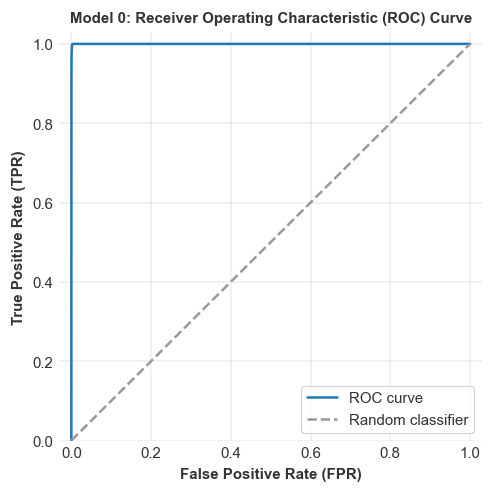

In [61]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

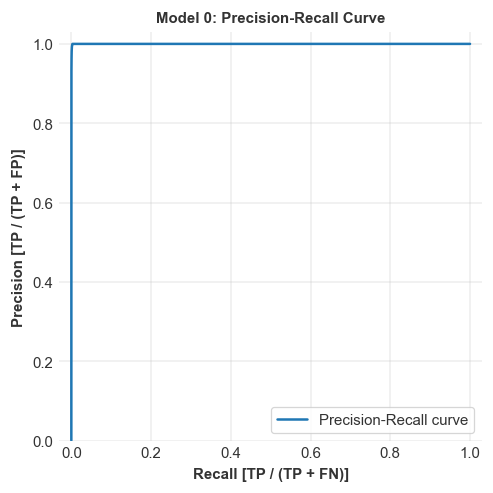

In [62]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

#### Feature importance


In [63]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
41,no_congen,2.112949e+06
34,ca_omph,1.261842e+06
30,ca_anen,1.120392e+06
36,ca_limb,1.012162e+06
33,ca_cdh,8.628512e+05
31,ca_mnsb,7.351641e+05
38,ca_clpal,7.350634e+05
35,ca_gast,6.162070e+05
32,ca_cchd,5.954477e+05
37,ca_cleft,4.836162e+05


### Evaluation subset for permutation importances and SHAP analysis


In [64]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

In [65]:
model_wrapped = ml_utils.LGBMEstimator(gbm)

In [66]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
41,no_congen,9.312881e-01,0.000256
39,ca_hypo,5.065586e-01,0.001142
32,ca_cchd,4.862642e-01,0.000881
37,ca_cleft,4.550566e-01,0.001215
40,ca_disor,3.759505e-01,0.000712
35,ca_gast,2.731572e-01,0.000631
38,ca_clpal,2.572396e-01,0.001289
31,ca_mnsb,2.013884e-01,0.000920
33,ca_cdh,1.818376e-01,0.000642
36,ca_limb,1.738654e-01,0.000664


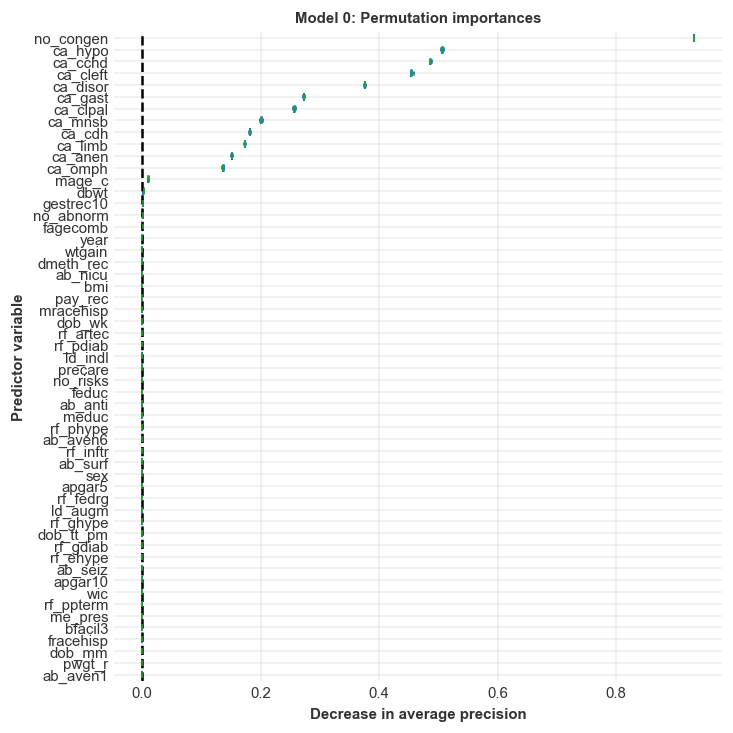

In [67]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

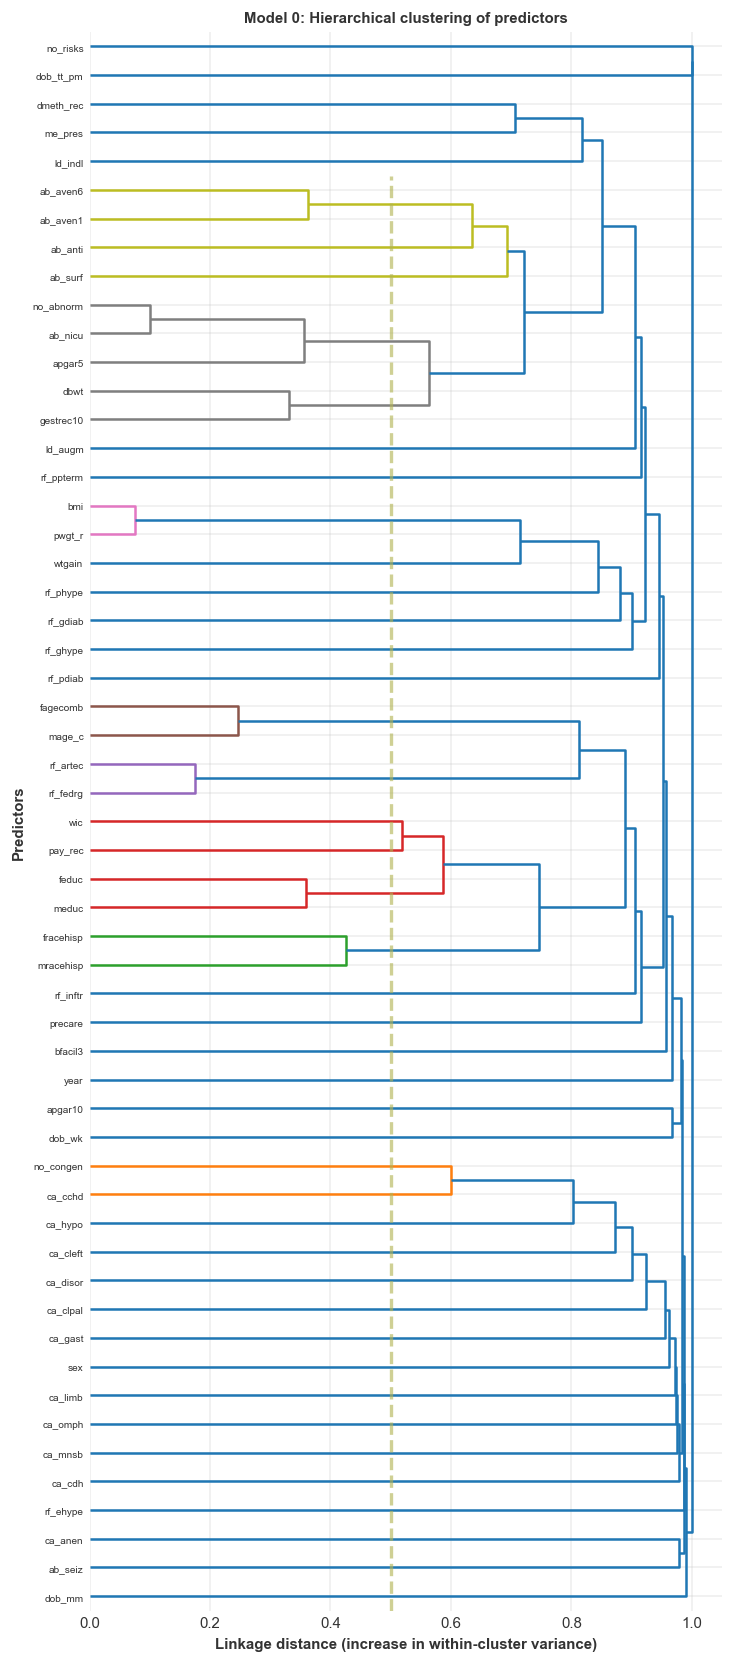

In [68]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

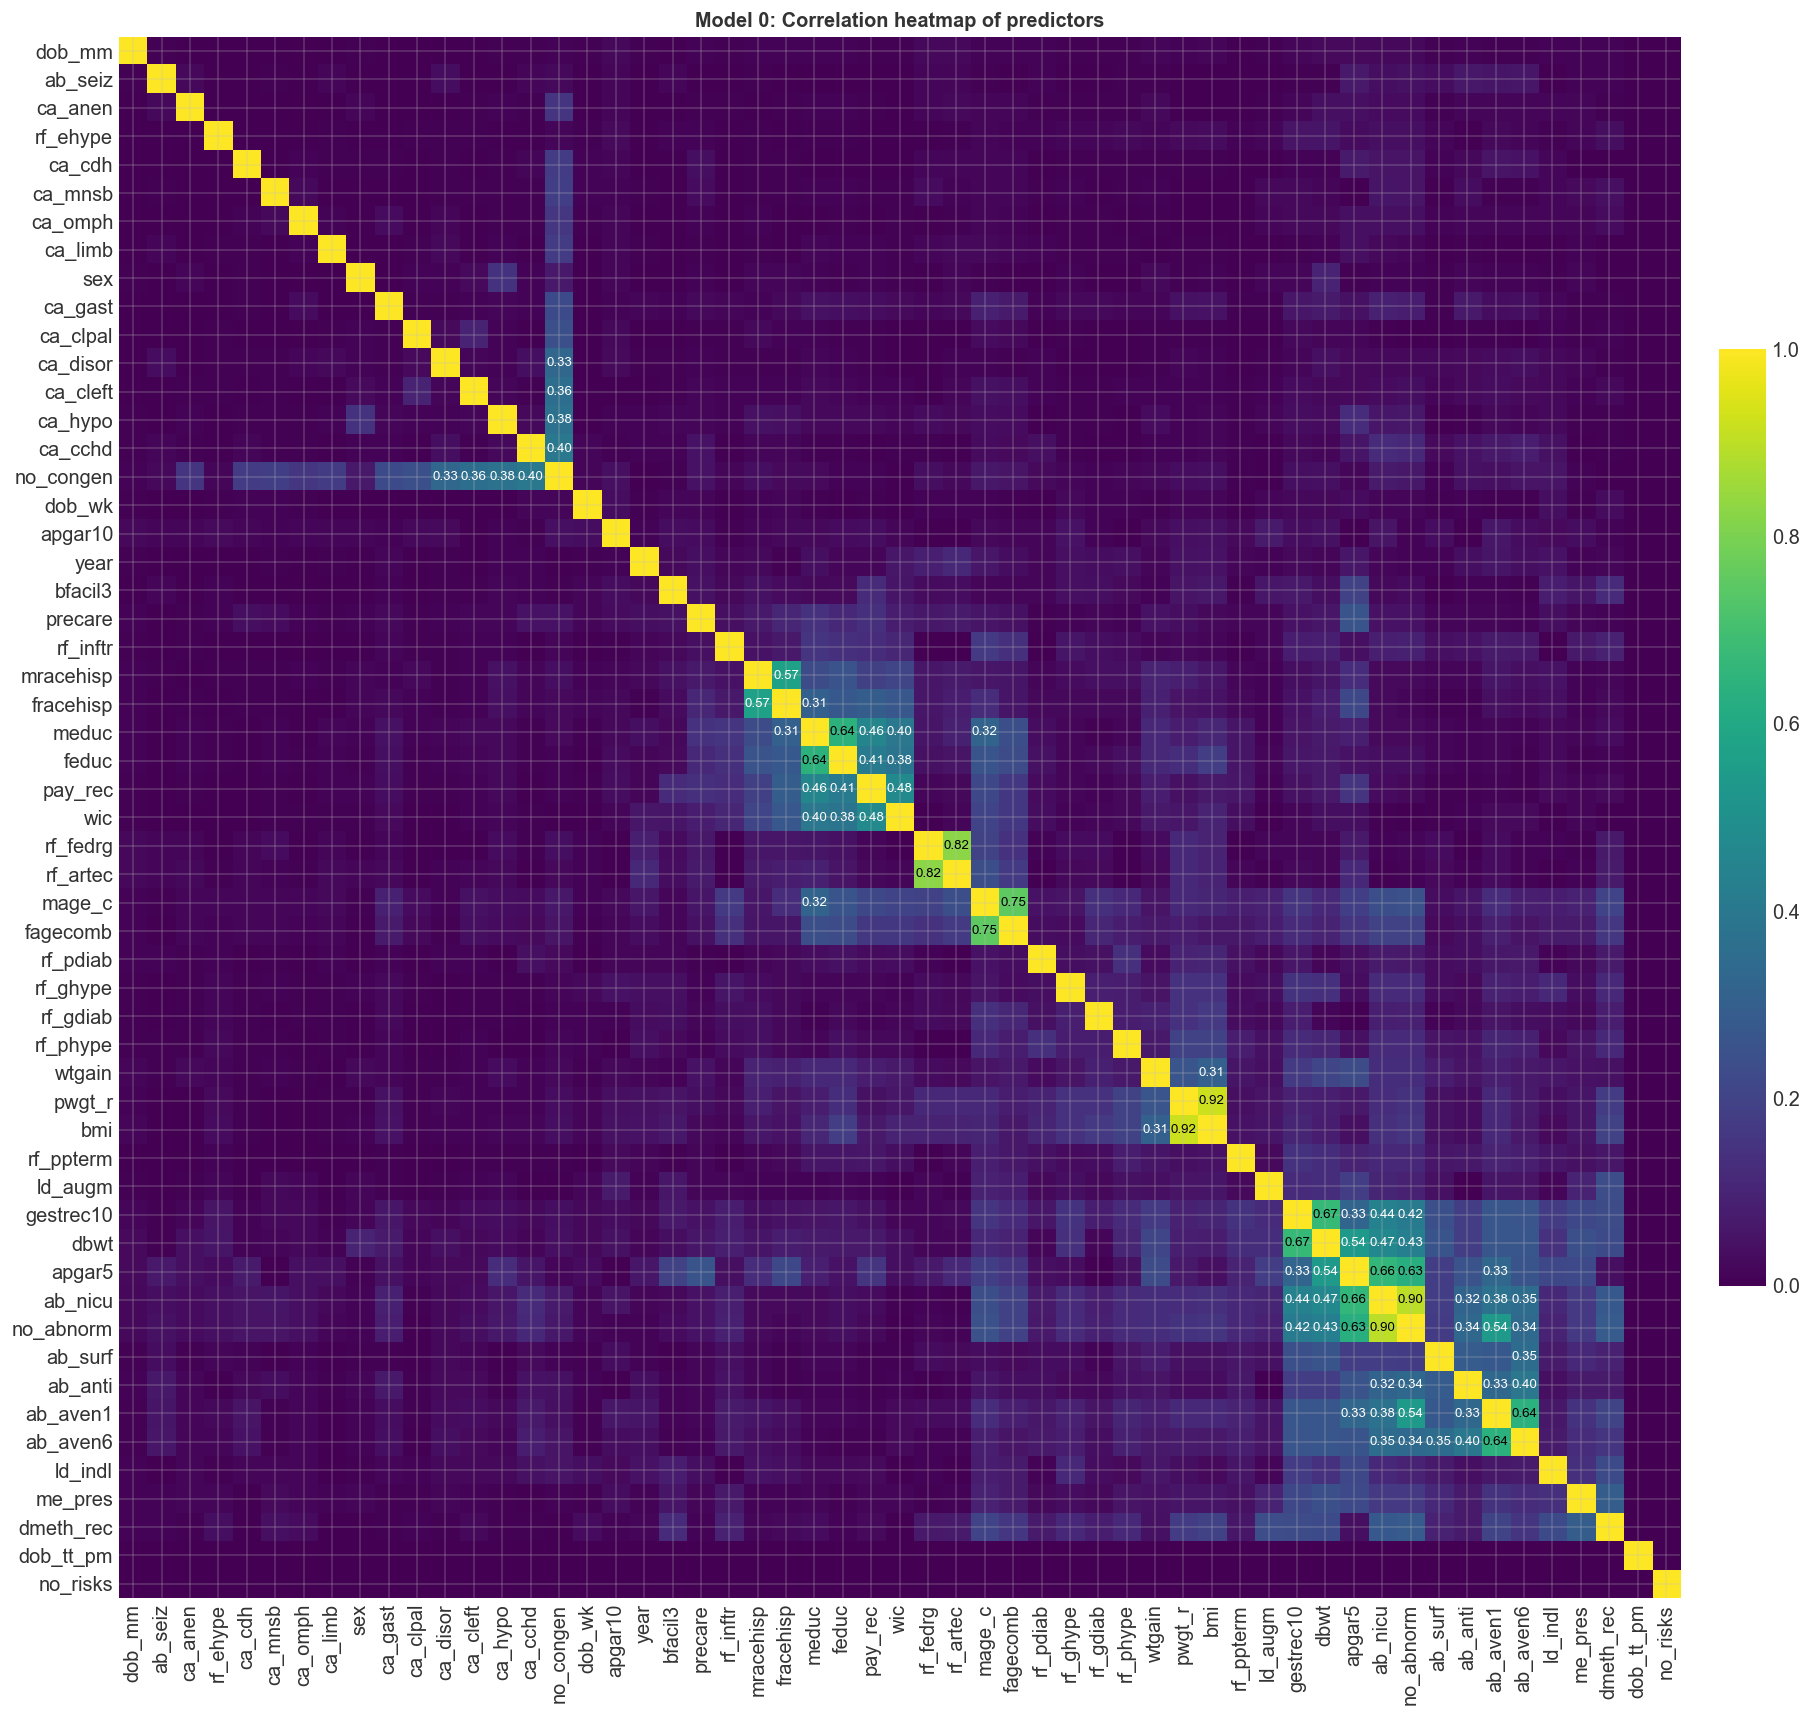

In [69]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [70]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clusterin

,feature,mean_abs_shap
41,no_congen,2.075603
32,ca_cchd,0.399052
39,ca_hypo,0.398303
37,ca_cleft,0.348922
40,ca_disor,0.300720
35,ca_gast,0.201675
38,ca_clpal,0.198434
31,ca_mnsb,0.160500
33,ca_cdh,0.155590
36,ca_limb,0.153940


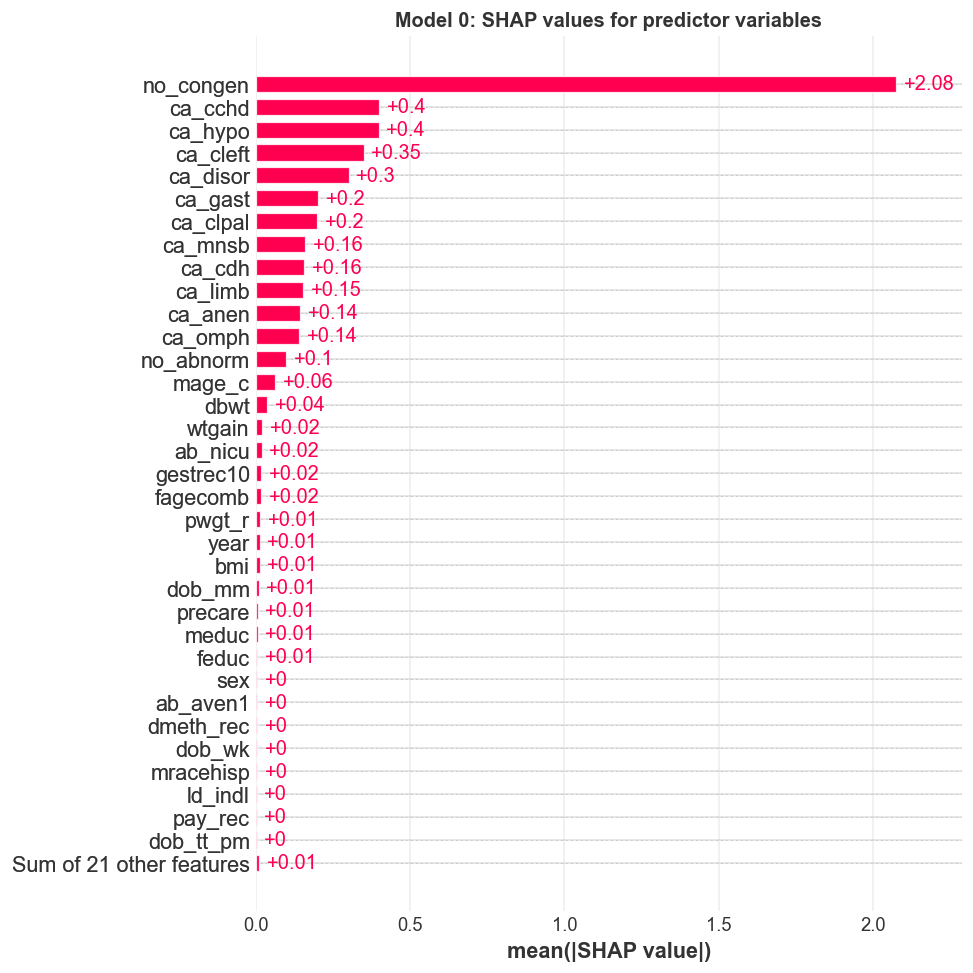

<Figure size 492x348 with 0 Axes>

In [71]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

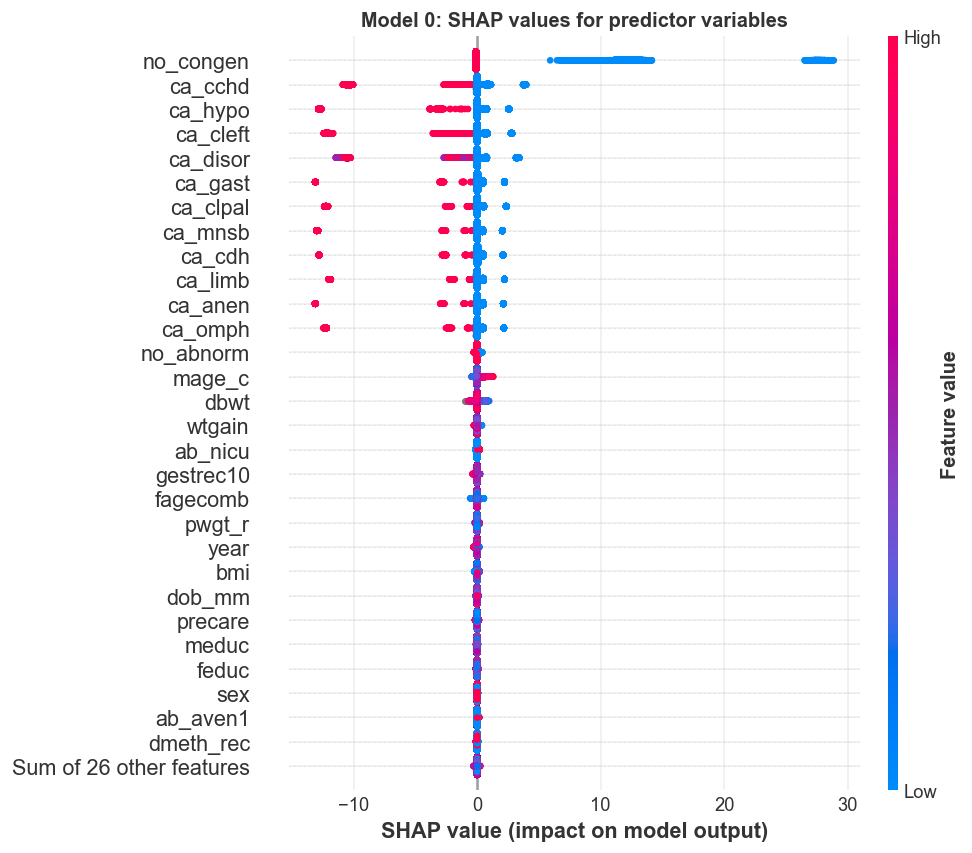

<Figure size 492x348 with 0 Axes>

In [72]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

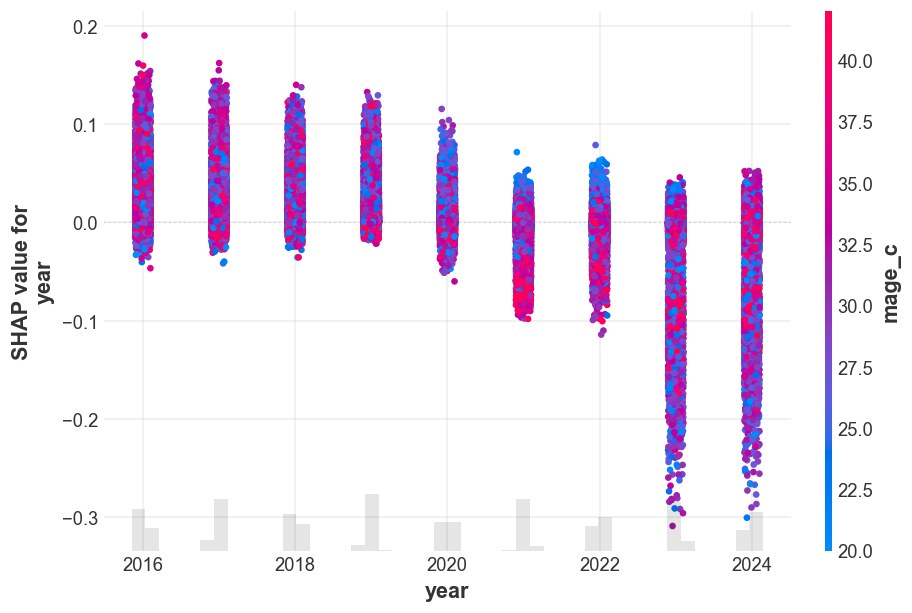

<Figure size 492x348 with 0 Axes>

In [73]:
ax = shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
# ax.set_title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 1


In [74]:
features_to_remove_0 = [
    "ld_augm",
    "rf_ehype",
    "sex",
    "pwgt_r",
]

X_train = X_train.drop(columns=features_to_remove_0)
X_valid = X_valid.drop(columns=features_to_remove_0)
X_cal = X_cal.drop(columns=features_to_remove_0)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_0]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 1
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_0)} predictors)"
)

print(f"Features removed: {features_to_remove_0}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

Features removed: ['ld_augm', 'rf_ehype', 'sex', 'pwgt_r']
Features remaining: ['dob_mm', 'dob_wk', 'dob_tt_pm', 'bfacil3', 'precare', 'gestrec10', 'rf_pdiab', 'rf_gdiab', 'rf_phype', 'rf_ghype', 'rf_ppterm', 'rf_inftr', 'rf_fedrg', 'rf_artec', 'no_risks', 'ld_indl', 'me_pres', 'dmeth_rec', 'apgar5', 'apgar10', 'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_surf', 'ab_anti', 'ab_seiz', 'no_abnorm', 'ca_anen', 'ca_mnsb', 'ca_cchd', 'ca_cdh', 'ca_omph', 'ca_gast', 'ca_limb', 'ca_cleft', 'ca_clpal', 'ca_hypo', 'ca_disor', 'no_congen', 'meduc', 'mracehisp', 'feduc', 'fracehisp', 'pay_rec', 'wic', 'year', 'dbwt', 'wtgain', 'bmi', 'mage_c', 'fagecomb']
Number of features in Model 1 (after removing 4 predictors): 51


In [75]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 904
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [76]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [77]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.990305
1,Validation AP,0.951718
2,Validation log loss,0.000411
3,Precision at 10000,0.432100
4,Recall at 10000,0.970575
5,Precision (threshold=0.01),0.328968
6,Recall (threshold=0.01),0.981806


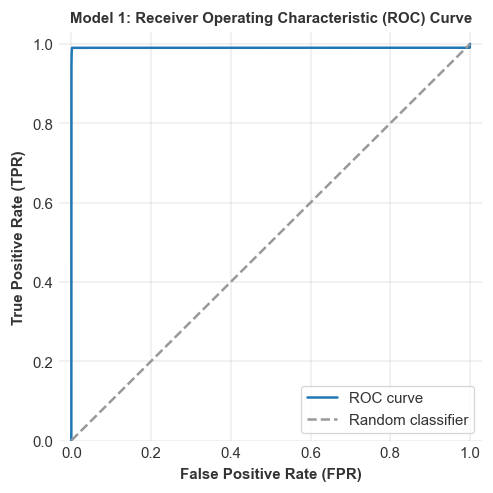

In [78]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

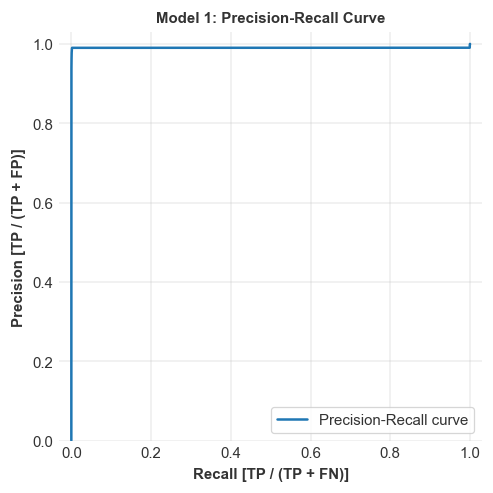

In [79]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [80]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
38,no_congen,2.108358e+06
31,ca_omph,9.066713e+05
36,ca_hypo,9.050607e+05
30,ca_cdh,8.631273e+05
27,ca_anen,8.346953e+05
35,ca_clpal,8.257218e+05
28,ca_mnsb,7.351786e+05
37,ca_disor,7.012449e+05
33,ca_limb,6.938358e+05
34,ca_cleft,6.529751e+05


In [81]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [82]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
38,no_congen,9.286035e-01,2.881869e-04
29,ca_cchd,3.511502e-01,1.627277e-03
37,ca_disor,2.799215e-01,1.113094e-03
36,ca_hypo,2.449381e-01,1.415104e-03
34,ca_cleft,2.334019e-01,1.947736e-03
33,ca_limb,7.039287e-02,5.242509e-04
49,mage_c,1.227524e-02,8.519864e-04
30,ca_cdh,2.735813e-03,4.405577e-04
32,ca_gast,2.354252e-03,1.662308e-04
46,dbwt,1.880846e-03,2.931340e-04


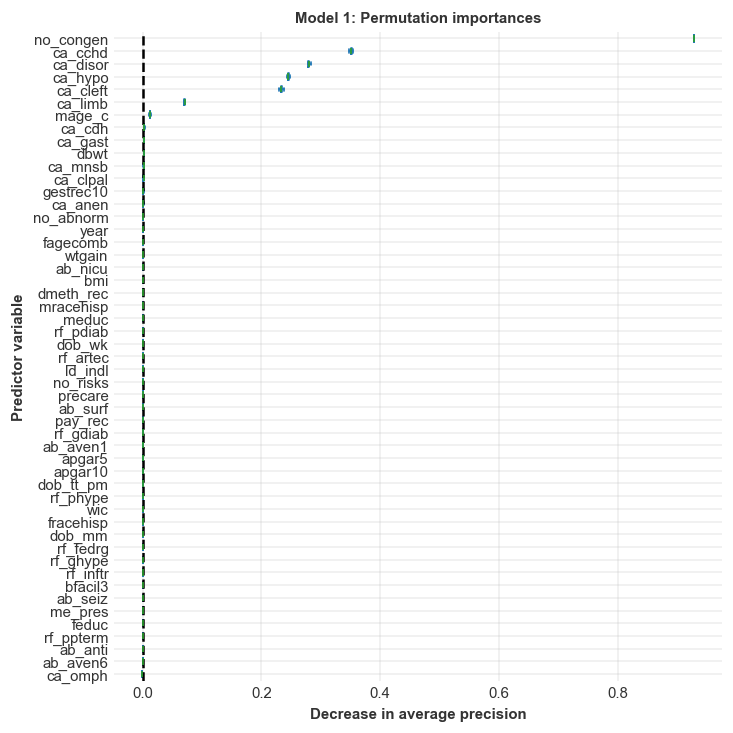

In [83]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

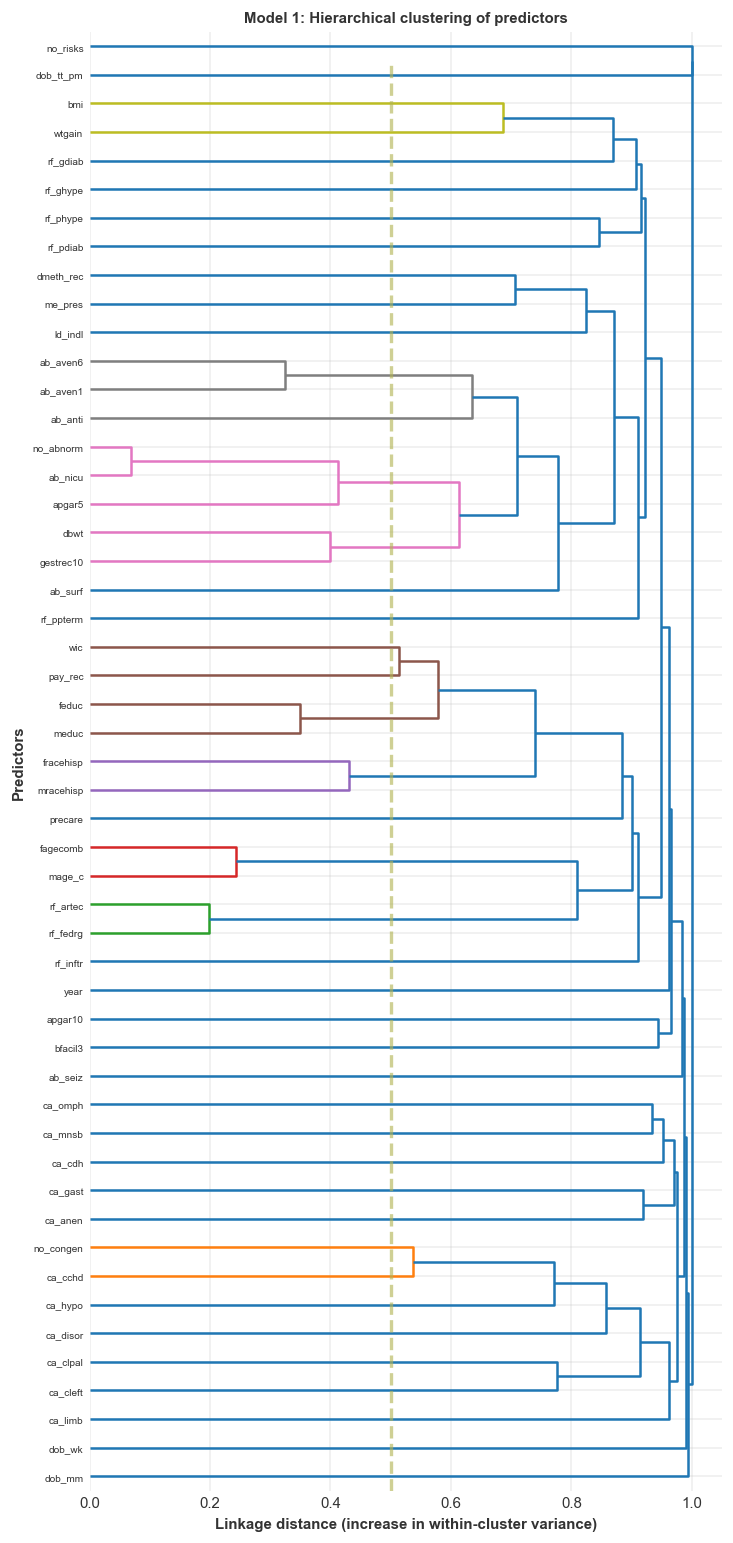

In [84]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

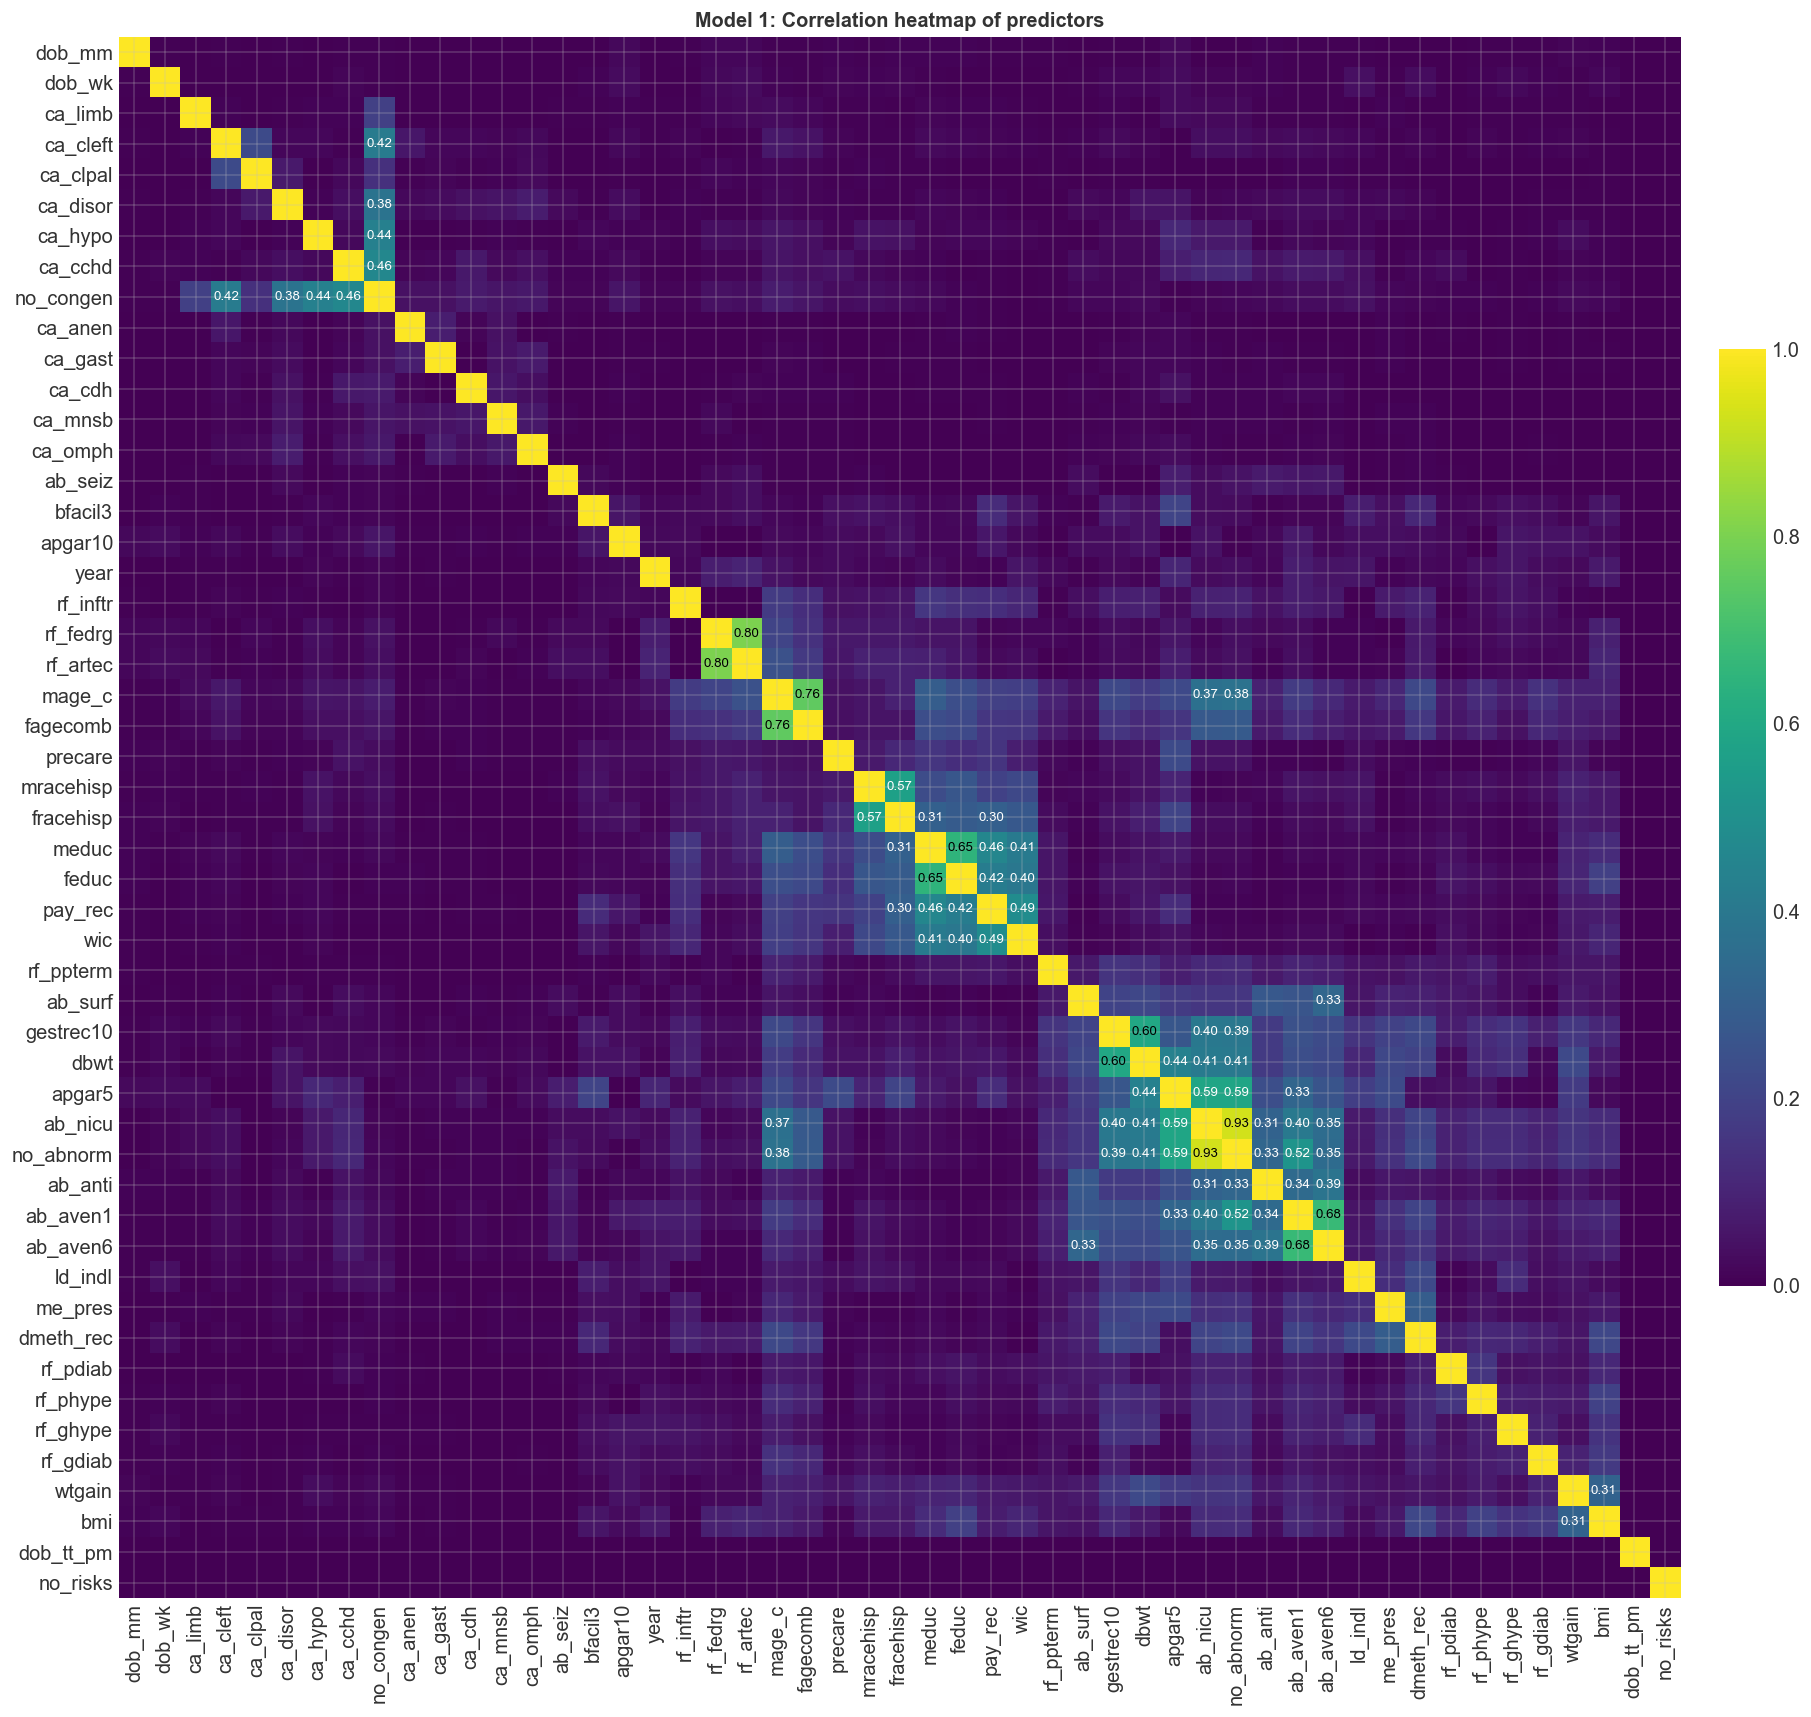

In [85]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [86]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clusterin

,feature,mean_abs_shap
38,no_congen,0.551118
29,ca_cchd,0.140094
36,ca_hypo,0.125712
32,ca_gast,0.085845
30,ca_cdh,0.081938
28,ca_mnsb,0.079044
34,ca_cleft,0.075780
33,ca_limb,0.073921
37,ca_disor,0.071068
35,ca_clpal,0.070841


In [87]:
shap_importance["feature"].tolist()

['no_congen',
 'ca_cchd',
 'ca_hypo',
 'ca_gast',
 'ca_cdh',
 'ca_mnsb',
 'ca_cleft',
 'ca_limb',
 'ca_disor',
 'ca_clpal',
 'ca_omph',
 'ca_anen',
 'no_abnorm',
 'mage_c',
 'ab_nicu',
 'dbwt',
 'wtgain',
 'gestrec10',
 'fagecomb',
 'bmi',
 'year',
 'dmeth_rec',
 'mracehisp',
 'precare',
 'feduc',
 'ab_aven6',
 'no_risks',
 'ld_indl',
 'ab_aven1',
 'ab_anti',
 'meduc',
 'dob_wk',
 'rf_artec',
 'rf_pdiab',
 'rf_ppterm',
 'pay_rec',
 'ab_surf',
 'apgar10',
 'bfacil3',
 'dob_tt_pm',
 'me_pres',
 'apgar5',
 'ab_seiz',
 'rf_gdiab',
 'rf_fedrg',
 'rf_phype',
 'rf_ghype',
 'dob_mm',
 'rf_inftr',
 'fracehisp',
 'wic']

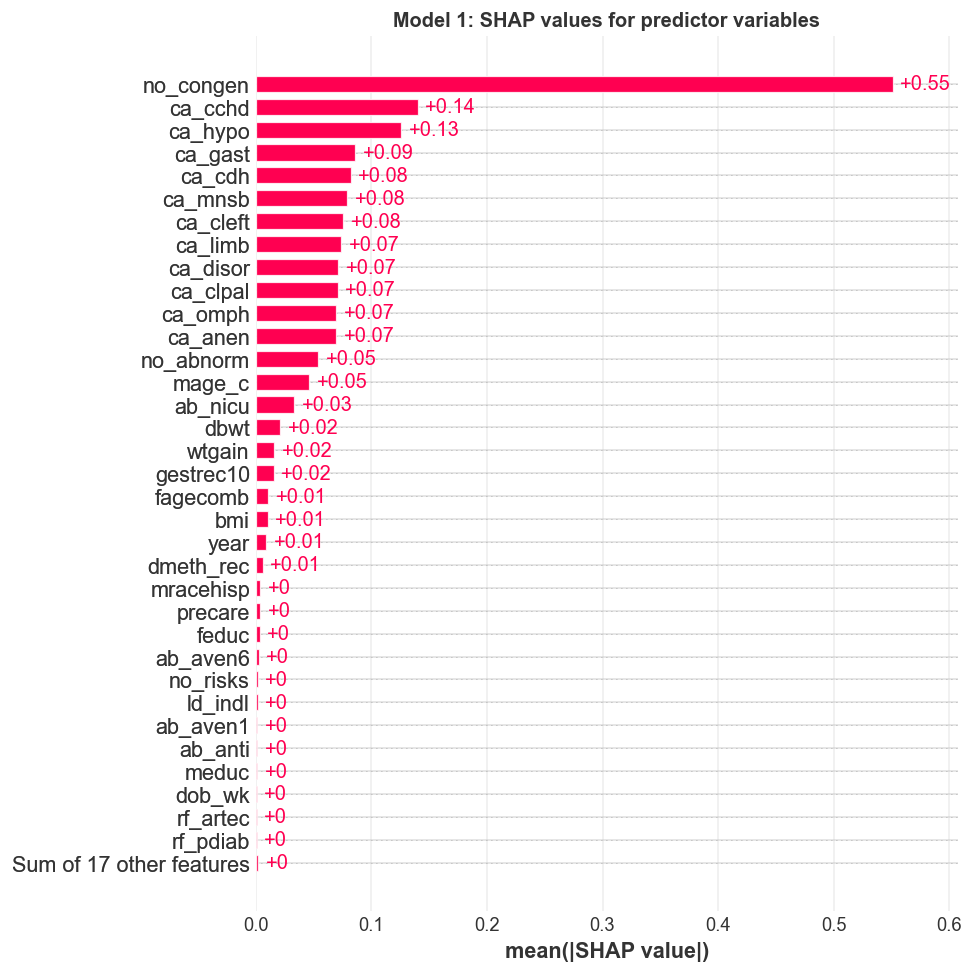

<Figure size 492x348 with 0 Axes>

In [88]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

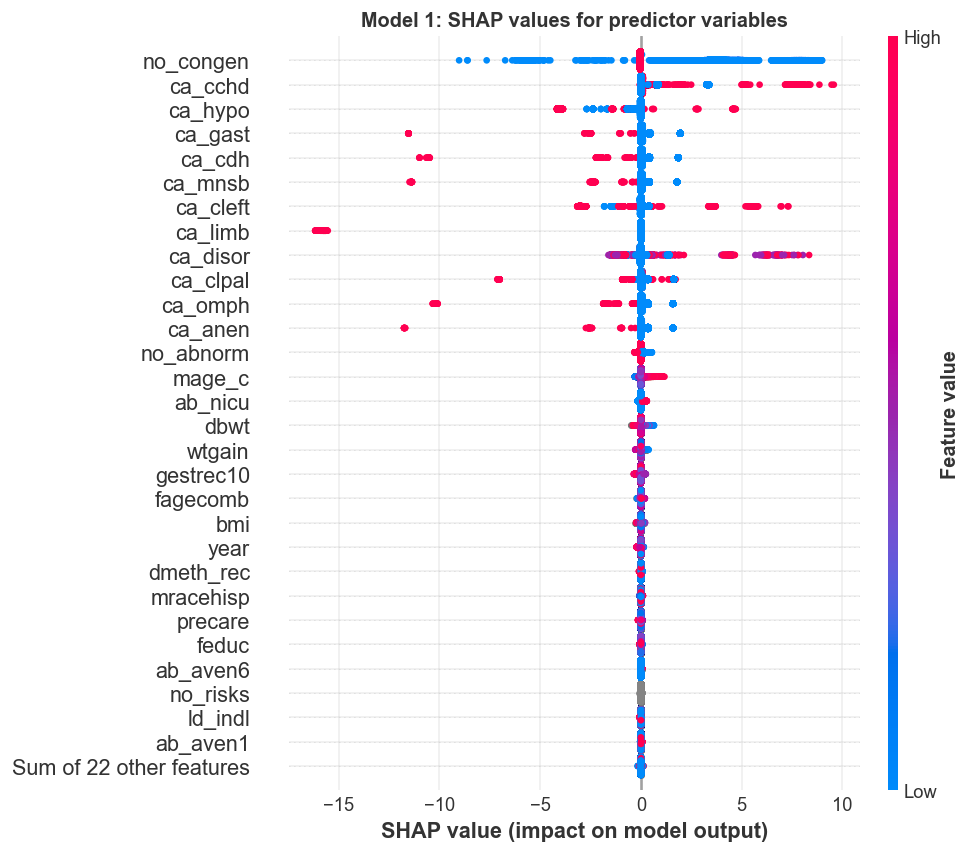

<Figure size 492x348 with 0 Axes>

In [89]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

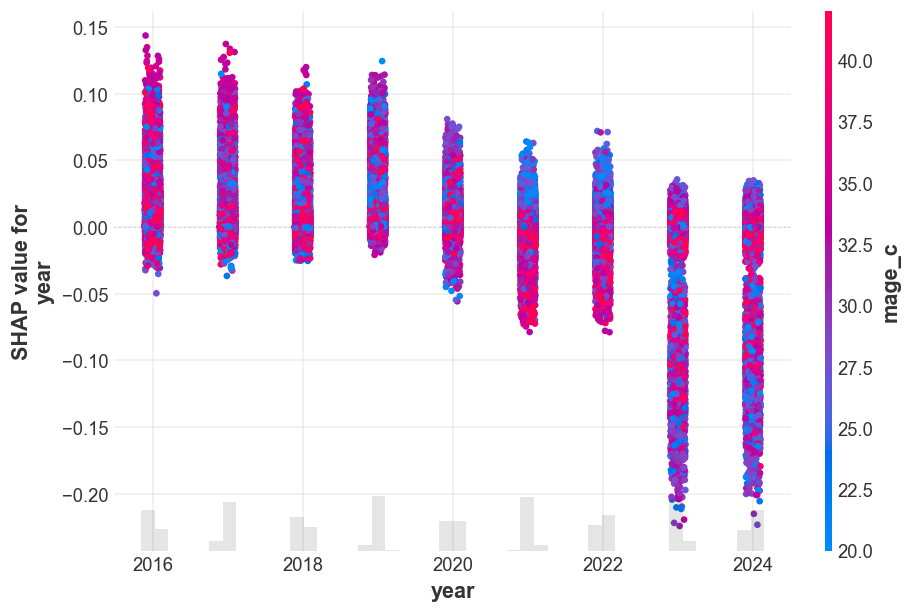

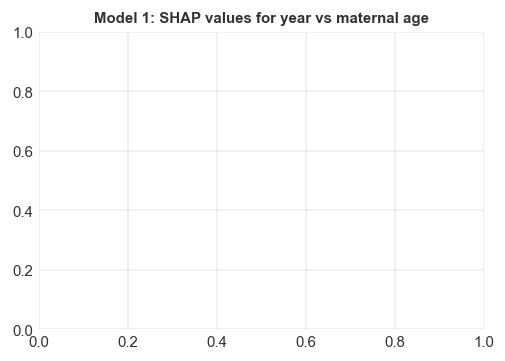

In [90]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
plt.title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 2


In [91]:
features_to_remove_1 = [
    "rf_ppterm",
]

X_train = X_train.drop(columns=features_to_remove_1)
X_valid = X_valid.drop(columns=features_to_remove_1)
X_cal = X_cal.drop(columns=features_to_remove_1)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_1]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 2
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_1)} predictors)"
)

print(f"Features removed: {features_to_remove_1}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

Features removed: ['rf_ppterm']
Features remaining: ['dob_mm', 'dob_wk', 'dob_tt_pm', 'bfacil3', 'precare', 'gestrec10', 'rf_pdiab', 'rf_gdiab', 'rf_phype', 'rf_ghype', 'rf_inftr', 'rf_fedrg', 'rf_artec', 'no_risks', 'ld_indl', 'me_pres', 'dmeth_rec', 'apgar5', 'apgar10', 'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_surf', 'ab_anti', 'ab_seiz', 'no_abnorm', 'ca_anen', 'ca_mnsb', 'ca_cchd', 'ca_cdh', 'ca_omph', 'ca_gast', 'ca_limb', 'ca_cleft', 'ca_clpal', 'ca_hypo', 'ca_disor', 'no_congen', 'meduc', 'mracehisp', 'feduc', 'fracehisp', 'pay_rec', 'wic', 'year', 'dbwt', 'wtgain', 'bmi', 'mage_c', 'fagecomb']
Number of features in Model 2 (after removing 1 predictors): 50


In [92]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 901
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [93]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [94]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.995681
1,Validation AP,0.951862
2,Validation log loss,0.000378
3,Precision at 10000,0.431500
4,Recall at 10000,0.969227
5,Precision (threshold=0.01),0.349744
6,Recall (threshold=0.01),0.982929


In [ ]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

In [ ]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [ ]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

In [ ]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [ ]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

In [ ]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

In [ ]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

In [ ]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [ ]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

In [ ]:
shap_importance["feature"].tolist()

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

In [ ]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
plt.title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Calibration


In [ ]:
p_cal_raw = gbm.predict(X_cal, num_iteration=gbm.best_iteration, raw_score=True)

In [ ]:
calibrator = LogisticRegression(solver="lbfgs", max_iter=1000)
calibrator.fit(p_cal_raw.reshape(-1, 1), y_cal)

In [ ]:
def predict_proba_calibrated(gbm, calibrator, X_new, num_iteration=None):
    p_raw = gbm.predict(X_new, num_iteration=num_iteration, raw_score=True)
    return calibrator.predict_proba(p_raw.reshape(-1, 1))[:, 1]

## Prediction


In [ ]:
p_valid_cal = predict_proba_calibrated(
    gbm, calibrator, X_valid, num_iteration=gbm.best_iteration
)

p_valid_raw = gbm.predict(X_valid, num_iteration=gbm.best_iteration, raw_score=False)

print("best_iteration:", gbm.best_iteration)
print("mean raw prob:", float(p_valid_raw.mean()))
print("mean cal prob:", float(p_valid_cal.mean()))


print("Raw logloss:", log_loss(y_valid, p_valid_raw, labels=[0, 1]))
print("Cal logloss:", log_loss(y_valid, p_valid_cal, labels=[0, 1]))
print("Raw brier:  ", brier_score_loss(y_valid, p_valid_raw))
print("Cal brier:  ", brier_score_loss(y_valid, p_valid_cal))

In [ ]:
def tail_calibration_table(y, p, fracs=(1e-2, 1e-3, 1e-4, 1e-5)):
    """
    Compare predicted vs observed event rates in the top fracs of scores.

    Parameters
    ----------
    y : array-like (0/1)
    p : array-like (probabilities)
    fracs : iterable of floats
        Fractions like 1e-3 for top 0.1%.

    Returns
    -------
    DataFrame with k, predicted mean, observed rate, and counts.
    """
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)

    order = np.argsort(-p)
    y_sorted = y[order]
    p_sorted = p[order]

    N = len(y)
    rows = []
    for f in fracs:
        k = max(1, int(round(N * f)))
        y_top = y_sorted[:k]
        p_top = p_sorted[:k]

        obs_rate = y_top.mean()
        pred_rate = p_top.mean()

        tp = int(y_top.sum())
        fp = int(k - tp)

        rows.append(
            {
                "top_frac": f,
                "k": k,
                "pred_rate_mean": pred_rate,
                "obs_rate": obs_rate,
                "tp": tp,
                "fp": fp,
                "pred_minus_obs": pred_rate - obs_rate,
                "ratio_pred_to_obs": (pred_rate / obs_rate) if obs_rate > 0 else np.nan,
            }
        )

    return pd.DataFrame(rows)

In [ ]:
fracs = (1e-2, 1e-3, 1e-4, 1e-5)  # 1%, 0.1%, 0.01%, 0.001%

calibration_table_raw = tail_calibration_table(y_valid, p_valid_raw, fracs=fracs)
calibration_table_cal = tail_calibration_table(y_valid, p_valid_cal, fracs=fracs)

calibration_table_raw["model"] = "raw"
calibration_table_cal["model"] = "calibrated"
calibration_table_combined = pd.concat(
    [calibration_table_raw, calibration_table_cal], ignore_index=True
)

calibration_table_combined.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_tail_calibration_table.csv",
    index=False,
)

calibration_table_combined

In [ ]:
gbm.save_model(
    f"{OUTPUT_DIR}/final_model_{model_idx}.txt",
    num_iteration=best_iter,
)

In [ ]:
joblib.dump(calibrator, f"{OUTPUT_DIR}/final_calibrator.joblib")

meta = {
    "features": list(X_train.columns),
    "best_iteration": int(getattr(gbm, "best_iteration", 0) or 0),
    "calibration_input": "raw_score",  # or "prob"
}

joblib.dump(meta, f"{OUTPUT_DIR}/final_model_meta.joblib")

In [ ]:
X_full = df[features]
p_full_cal = predict_proba_calibrated(
    gbm, calibrator, X_full, num_iteration=gbm.best_iteration
)

In [ ]:
df["p_ds_lb_pred_01"] = p_full_cal

In [ ]:
df[["year", "p_ds_lb_pred"]].groupby("year").sum().reset_index()

In [ ]:
import duckdb

con = duckdb.connect("./data/us_births.db")

In [ ]:
con.execute(
    """
    ALTER TABLE us_births ADD COLUMN IF NOT EXISTS p_ds_lb_pred_01 DOUBLE;
    """
)
con.execute("DROP TABLE IF EXISTS ds_lb_pred_01")
con.execute(f"CREATE TABLE ds_lb_pred_01 (id BIGINT, p_ds_lb_pred DOUBLE)")

In [ ]:
con.execute(
    """
    INSERT INTO ds_lb_pred_01 (id, p_ds_lb_pred)
    SELECT id, p_ds_lb_pred_01
    FROM df
    """
)

In [ ]:
con.execute(
    """
    UPDATE us_births b
    SET p_ds_lb_pred_01 = p.p_ds_lb_pred
    FROM ds_lb_pred_01 p
    WHERE b.id = p.id;
    """
)

In [ ]:
con.execute("DROP TABLE IF EXISTS ds_lb_pred_01")

In [ ]:
con.close()